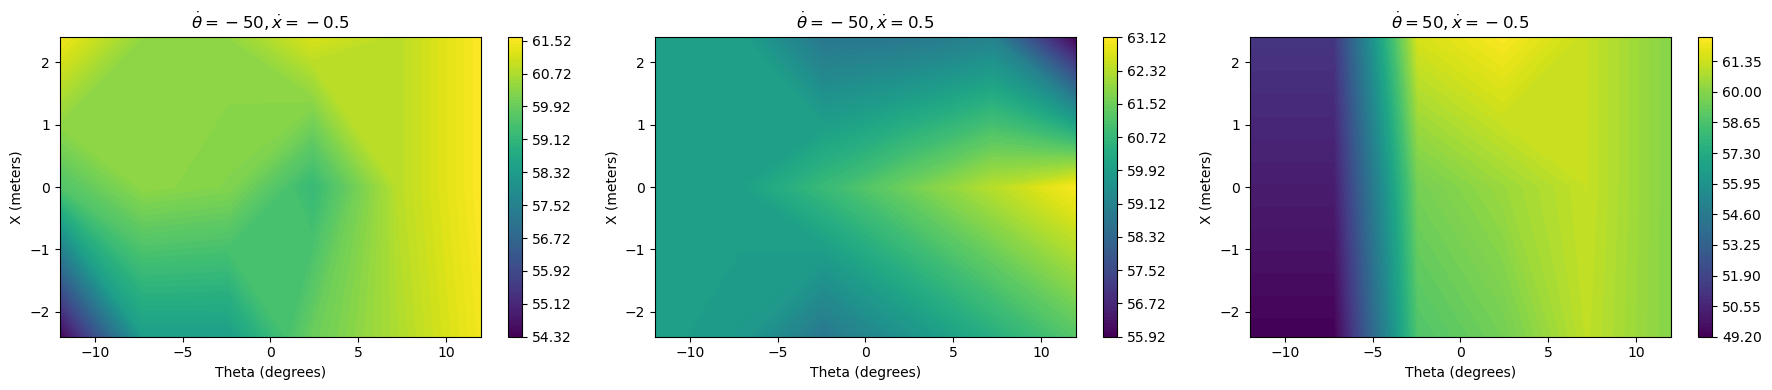

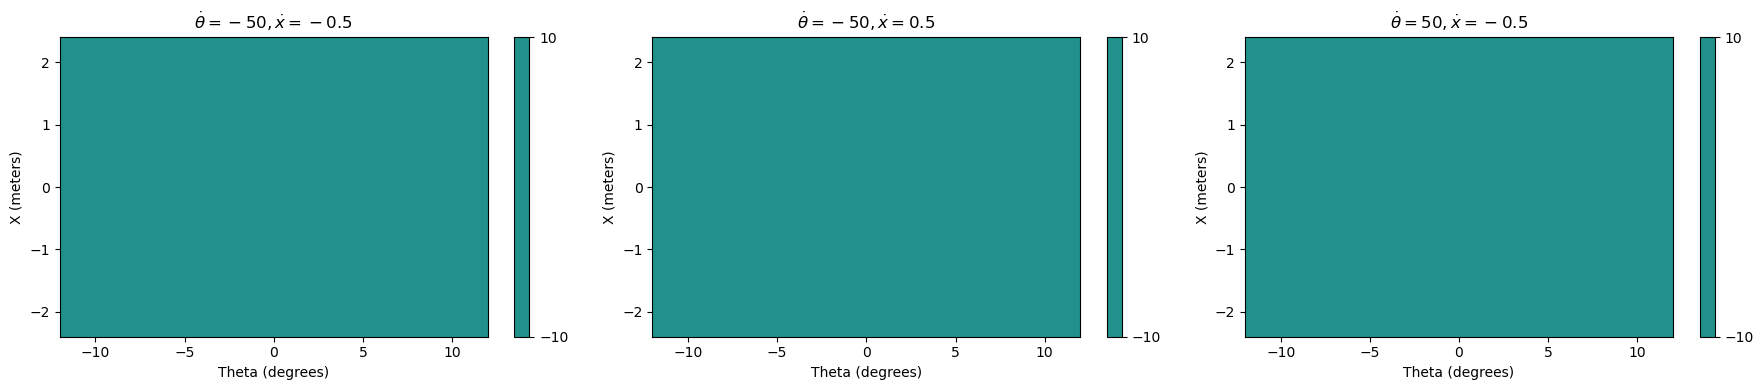

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Define the system parameters
M = 1.0  # mass of the cart
m = 0.1  # mass of the pole
g = -9.8  # acceleration due to gravity
l = 0.5  # half-length of the pole
mu_c = 0.0005  # coefficient of friction of the cart
mu_p = 0.00002  # coefficient of friction of the pole
actions = np.array([10, -10])  # possible actions (force on the cart)
delta_t = 0.02  # time step for integration
gamma = 0.99  # discount factor

# Discretize the state space
theta_bins = np.linspace(-12, 12, 6)  # theta discretization
x_bins = np.linspace(-2.4, 2.4, 3)  # x discretization
theta_dot_bins = np.array([-50, 50])  # theta_dot discretization (open-ended)
x_dot_bins = np.array([-0.5, 0.5])  # x_dot discretization (open-ended)

# Initialize the value function
state_values = np.zeros((len(theta_bins), len(x_bins), len(theta_dot_bins), len(x_dot_bins)))

# Define the reward function
def reward(theta, x):
    if abs(theta) <= 12 and abs(x) <= 2.4:
        return 1  # Reward for keeping the pole balanced
    else:
        return -1  # Penalty for failing to keep the pole balanced

# Define the dynamics of the system
def dynamics(theta, x, theta_dot, x_dot, force):
    sin_theta = np.sin(np.radians(theta))
    cos_theta = np.cos(np.radians(theta))
    theta_ddot = (g * sin_theta + cos_theta * (-force - m*l*theta_dot**2*sin_theta + mu_c * np.sign(x_dot)) / (M + m)) / \
                 (l * (4/3 - m*cos_theta**2 / (m + M)))
    x_ddot = (force + m*l*(theta_dot**2*sin_theta - theta_ddot*cos_theta) - mu_c*np.sign(x_dot)) / (M + m)
    return theta_ddot, x_ddot

# Value iteration algorithm
def value_iteration(state_values, theta_bins, x_bins, theta_dot_bins, x_dot_bins, iterations=1000):
    for iteration in range(iterations):
        delta = 0
        for i, theta in enumerate(theta_bins):
            for j, x in enumerate(x_bins):
                for k, theta_dot in enumerate(theta_dot_bins):
                    for l, x_dot in enumerate(x_dot_bins):
                        v = state_values[i, j, k, l]
                        max_value = float('-inf')
                        for action in actions:
                            # Apply dynamics to get new state
                            theta_ddot, x_ddot = dynamics(theta, x, theta_dot, x_dot, action)
                            # Update state with Euler's method
                            new_theta_dot = theta_dot + theta_ddot * delta_t
                            new_x_dot = x_dot + x_ddot * delta_t
                            new_theta = theta + new_theta_dot * delta_t
                            new_x = x + new_x_dot * delta_t
                            # Get reward for new state
                            r = reward(new_theta, new_x)
                            # Discretize new state
                            new_i = np.digitize(new_theta, theta_bins) - 1
                            new_j = np.digitize(new_x, x_bins) - 1
                            new_k = np.digitize(new_theta_dot, theta_dot_bins, right=True) - 1
                            new_l = np.digitize(new_x_dot, x_dot_bins, right=True) - 1
                            # Calculate the value
                            value = r + gamma * state_values[new_i, new_j, new_k, new_l]
                            max_value = max(max_value, value)
                        # Update the value function for the state
                        state_values[i, j, k, l] = max_value
                        # Calculate the maximum change in value function
                        delta = max(delta, abs(v - max_value))
        # Check for convergence (if the change is smaller than a threshold)
        if delta < 1e-3:
            break
    return state_values

# Execute the provided value iteration code to get the state values
computed_state_values = value_iteration(state_values, theta_bins, x_bins, theta_dot_bins, x_dot_bins)

# Now, let's generate the plots of the value function with respect to theta and x
# for selected theta_dot and x_dot. We need at least three plots as requested.

# For plotting, we select three different combinations of theta_dot and x_dot:
# 1. theta_dot = -50, x_dot = -0.5
# 2. theta_dot = -50, x_dot = 0.5
# 3. theta_dot = 50, x_dot = -0.5
# Note: These combinations are arbitrary and can be changed as needed.

# Create the plots
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# Set titles for subplots
titles = [
    '$\\dot{\\theta} = -50, \\dot{x} = -0.5$',
    '$\\dot{\\theta} = -50, \\dot{x} = 0.5$',
    '$\\dot{\\theta} = 50, \\dot{x} = -0.5$'
]

# Iterate over the selected theta_dot and x_dot combinations and plot
for idx, (theta_dot_idx, x_dot_idx) in enumerate([(0, 0), (0, 1), (1, 0)]):
    value_slice = computed_state_values[:, :, theta_dot_idx, x_dot_idx]
    theta, x = np.meshgrid(theta_bins, x_bins)
    cp = axes[idx].contourf(theta, x, value_slice.T, cmap='viridis', levels=100)
    fig.colorbar(cp, ax=axes[idx])
    axes[idx].set_title(titles[idx])
    axes[idx].set_xlabel('Theta (degrees)')
    axes[idx].set_ylabel('X (meters)')

plt.tight_layout()
plt.show()



# To plot the optimal policy, we need to determine the best action for each state based on the computed values.
# This involves looking at the expected return of each possible action from each state and selecting the one
# with the highest return.

# Define a function to determine the optimal policy from the state values
def compute_optimal_policy(state_values, theta_bins, x_bins, theta_dot_bins, x_dot_bins, actions):
    policy = np.zeros(state_values.shape, dtype=int)

    for i, theta in enumerate(theta_bins):
        for j, x in enumerate(x_bins):
            for k, theta_dot in enumerate(theta_dot_bins):
                for l, x_dot in enumerate(x_dot_bins):
                    action_values = []
                    for action in actions:
                        # Apply dynamics to get new state
                        theta_ddot, x_ddot = dynamics(theta, x, theta_dot, x_dot, action)
                        # Update state with Euler's method
                        new_theta_dot = theta_dot + theta_ddot * delta_t
                        new_x_dot = x_dot + x_ddot * delta_t
                        new_theta = theta + new_theta_dot * delta_t
                        new_x = x + new_x_dot * delta_t
                        # Discretize new state
                        new_i = np.digitize(new_theta, theta_bins) - 1
                        new_j = np.digitize(new_x, x_bins) - 1
                        new_k = np.digitize(new_theta_dot, theta_dot_bins, right=True) - 1
                        new_l = np.digitize(new_x_dot, x_dot_bins, right=True) - 1
                        # Ensure we don't go out of bounds
                        new_i = max(0, min(new_i, len(theta_bins) - 1))
                        new_j = max(0, min(new_j, len(x_bins) - 1))
                        new_k = max(0, min(new_k, len(theta_dot_bins) - 1))
                        new_l = max(0, min(new_l, len(x_dot_bins) - 1))
                        # Calculate the value
                        value = state_values[new_i, new_j, new_k, new_l]
                        action_values.append(value)
                    # Select the action with the highest value
                    best_action_idx = np.argmax(action_values)
                    policy[i, j, k, l] = actions[best_action_idx]
    return policy

# Compute the optimal policy
optimal_policy = compute_optimal_policy(computed_state_values, theta_bins, x_bins, theta_dot_bins, x_dot_bins, actions)
# Plot the optimal policy for the same slices as the value function plots
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# Iterate over the selected theta_dot and x_dot combinations and plot the optimal policy
for idx, (theta_dot_idx, x_dot_idx) in enumerate([(0, 0), (0, 1), (1, 0)]):
    policy_slice = optimal_policy[:, :, theta_dot_idx, x_dot_idx]
    theta, x = np.meshgrid(theta_bins, x_bins)
    cp = axes[idx].contourf(theta, x, policy_slice.T, cmap='viridis', levels=np.unique(policy_slice))
    fig.colorbar(cp, ax=axes[idx])
    axes[idx].set_title(titles[idx])
    axes[idx].set_xlabel('Theta (degrees)')
    axes[idx].set_ylabel('X (meters)')

plt.tight_layout()
plt.show()


